In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [21]:
import os
import pandas as pd

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/dataset'

# Define the labels and their corresponding folder names
labels = ['NORMAL', 'PNEUMONIA']

# Initialize empty lists to store image paths and labels
image_paths = []
labels_list = []

# Iterate through each label folder
for label in labels:
    label_folder_path = os.path.join(dataset_path, label)
    # Iterate through each image in the label folder
    for image_name in os.listdir(label_folder_path):
        # Construct the full path to the image
        image_path = os.path.join(label_folder_path, image_name)
        # Append the image path and label to the lists
        image_paths.append(image_path)
        labels_list.append(label)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'Image_Path': image_paths,
    'Label': labels_list
})

In [22]:
df

,Image_Path,Label
0,/content/drive/MyDrive/dataset/NORMAL/IM-0520-...,NORMAL
1,/content/drive/MyDrive/dataset/NORMAL/IM-0523-...,NORMAL
2,/content/drive/MyDrive/dataset/NORMAL/IM-0542-...,NORMAL
3,/content/drive/MyDrive/dataset/NORMAL/IM-0553-...,NORMAL
4,/content/drive/MyDrive/dataset/NORMAL/IM-0549-...,NORMAL
...,...,...
5851,/content/drive/MyDrive/dataset/PNEUMONIA/perso...,PNEUMONIA
5852,/content/drive/MyDrive/dataset/PNEUMONIA/perso...,PNEUMONIA
5853,/content/drive/MyDrive/dataset/PNEUMONIA/perso...,PNEUMONIA
5854,/content/drive/MyDrive/dataset/PNEUMONIA/perso...,PNEUMONIA


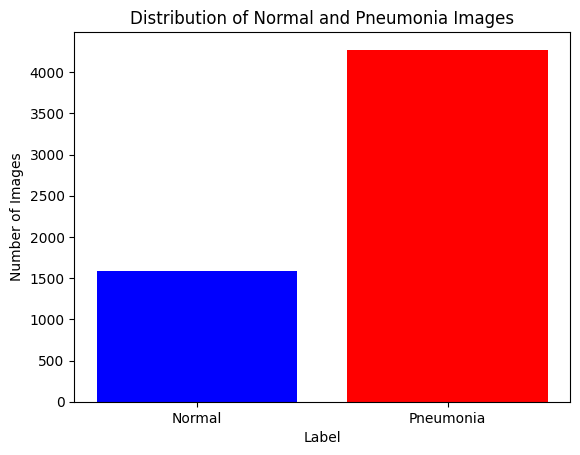

In [44]:
import os
import matplotlib.pyplot as plt

# Specify the path to your dataset
dataset_path = '/content/drive/MyDrive/dataset'

# Define the labels and their corresponding folder names
labels = ['NORMAL', 'PNEUMONIA']

# Initialize counters for each label
normal_count = 0
pneumonia_count = 0

# Iterate through each label folder and count the images
for label in labels:
    label_folder_path = os.path.join(dataset_path, label)
    image_count = len(os.listdir(label_folder_path))

    if label == 'NORMAL':
        normal_count += image_count
    elif label == 'PNEUMONIA':
        pneumonia_count += image_count

# Create a bar plot
labels = ['Normal', 'Pneumonia']
counts = [normal_count, pneumonia_count]

plt.bar(labels, counts, color=['blue', 'red'])
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.title('Distribution of Normal and Pneumonia Images')
plt.show()

In [23]:
from sklearn.model_selection import train_test_split

# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and channels
img_size = (224, 224)
channels = 3
batch_size = 32
img_shape = (img_size[0], img_size[1], channels)

# Determine test batch size dynamically based on the length of the test dataset
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Define a function for the preprocessing step during data augmentation (currently a no-op)
def no_op_preprocessing(img):
    return img

# Create ImageDataGenerator for training and testing with specified preprocessing function
tr_gen = ImageDataGenerator(preprocessing_function=no_op_preprocessing)
ts_gen = ImageDataGenerator(preprocessing_function=no_op_preprocessing)

# Set up data generators for training, validation, and testing
train_gen = tr_gen.flow_from_dataframe(dataframe=train_df, x_col='Image_Path', y_col='Label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(dataframe=valid_df, x_col='Image_Path', y_col='Label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

# Using a custom test batch size and setting shuffle to false for testing
test_gen = ts_gen.flow_from_dataframe(dataframe=test_df, x_col='Image_Path', y_col='Label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)


Found 4684 validated image filenames belonging to 2 classes.
Found 703 validated image filenames belonging to 2 classes.
Found 469 validated image filenames belonging to 2 classes.


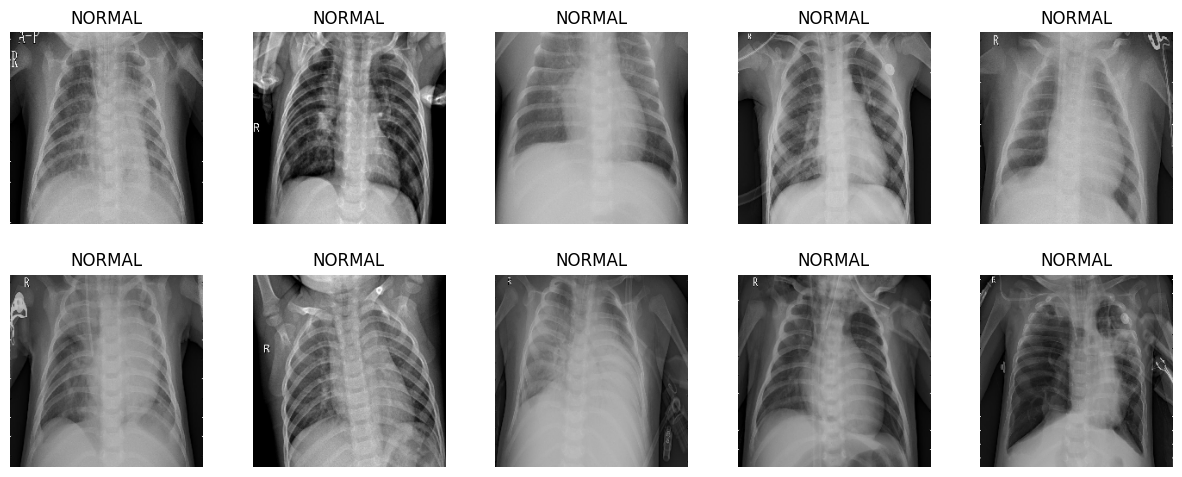

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Set the number of images to display
num_images = 10

# Get a batch of images from the training generator
sample_images, sample_labels = next(train_gen)

# Normalize image data to the range [0.0, 1.0]
sample_images_normalized = sample_images / 255.0

# Create a grid to display the images
fig = plt.figure(figsize=(15, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.5)

# Display the sample images with their labels
for ax, img, label in zip(grid, sample_images_normalized, sample_labels):
    ax.imshow(img)
    # Check if any element in the one-hot encoded label array is equal to 1
    ax.set_title('{}'.format('NORMAL' if any(label == 1) else 'PNEUMONIA'))
    ax.axis('off')

plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a Global Average Pooling layer to reduce the number of parameters
x = GlobalAveragePooling2D()(base_model.output)

# Add a Dense layer with softmax activation for classification
output = Dense(len(df['Label'].unique()), activation='softmax')(x)

# Create the ChexNet model
chexnet_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
chexnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
chexnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

In [27]:
# Set batch size for training
batch_size = 32

# Set the number of epochs
epochs = 5

# Train the model
history = chexnet_model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False
)

Epoch 1/5
147/147 [==============================] - 4847s 32s/step - loss: 0.1342 - accuracy: 0.9507 - val_loss: 0.0943 - val_accuracy: 0.9673
Epoch 2/5
147/147 [==============================] - 4712s 32s/step - loss: 0.0422 - accuracy: 0.9861 - val_loss: 0.1112 - val_accuracy: 0.9687
Epoch 3/5
147/147 [==============================] - 4722s 32s/step - loss: 0.0171 - accuracy: 0.9942 - val_loss: 0.0790 - val_accuracy: 0.9787
Epoch 4/5
147/147 [==============================] - 4729s 32s/step - loss: 0.0177 - accuracy: 0.9944 - val_loss: 0.0668 - val_accuracy: 0.9801
Epoch 5/5
147/147 [==============================] - 4716s 32s/step - loss: 0.0137 - accuracy: 0.9953 - val_loss: 0.0511 - val_accuracy: 0.9886


In [28]:
# Save the model
chexnet_model.save('chexnet_model.h5')

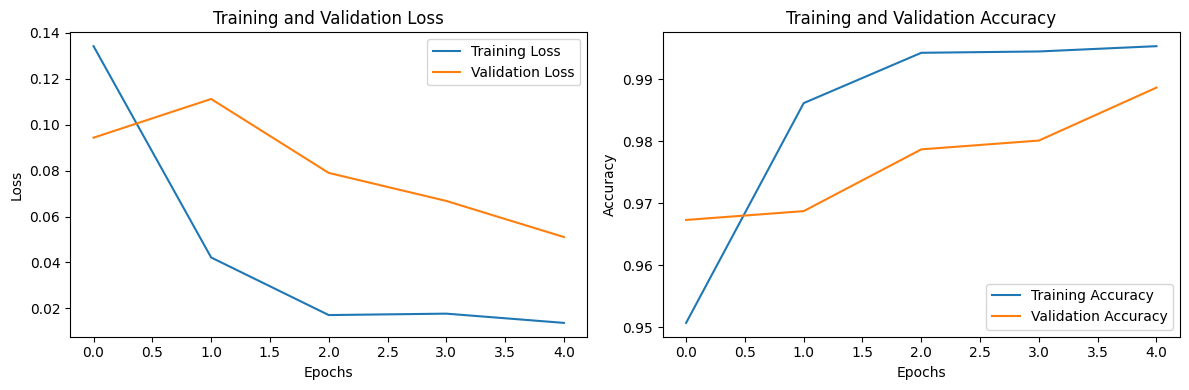

In [29]:
import matplotlib.pyplot as plt


# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

In [30]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# Evaluate the model on the training set
train_evaluation = chexnet_model.evaluate(train_gen, verbose=1, steps= test_steps)

# Evaluate the model on the validation set
valid_evaluation = chexnet_model.evaluate(valid_gen, verbose=1, steps= test_steps)

# Evaluate the model on the test set
test_evaluation = chexnet_model.evaluate(test_gen, verbose=1, steps= test_steps)

# Display the evaluation results
print("Training Set Evaluation:")
print(f"Loss: {train_evaluation[0]}, Accuracy: {train_evaluation[1]}")

print("\nValidation Set Evaluation:")
print(f"Loss: {valid_evaluation[0]}, Accuracy: {valid_evaluation[1]}")

print("\nTest Set Evaluation:")
print(f"Loss: {test_evaluation[0]}, Accuracy: {test_evaluation[1]}")

7/7 [==============================] - 100s 14s/step - loss: 0.0559 - accuracy: 0.9829
Training Set Evaluation:
Loss: 0.001962298294529319, Accuracy: 1.0

Validation Set Evaluation:
Loss: 0.06592154502868652, Accuracy: 0.9866071343421936

Test Set Evaluation:
Loss: 0.055850546807050705, Accuracy: 0.9829424023628235


In [31]:
import numpy as np

# Get predictions for the test set
predictions = chexnet_model.predict(test_gen, verbose=1)

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

7/7 [==============================] - 105s 14s/step


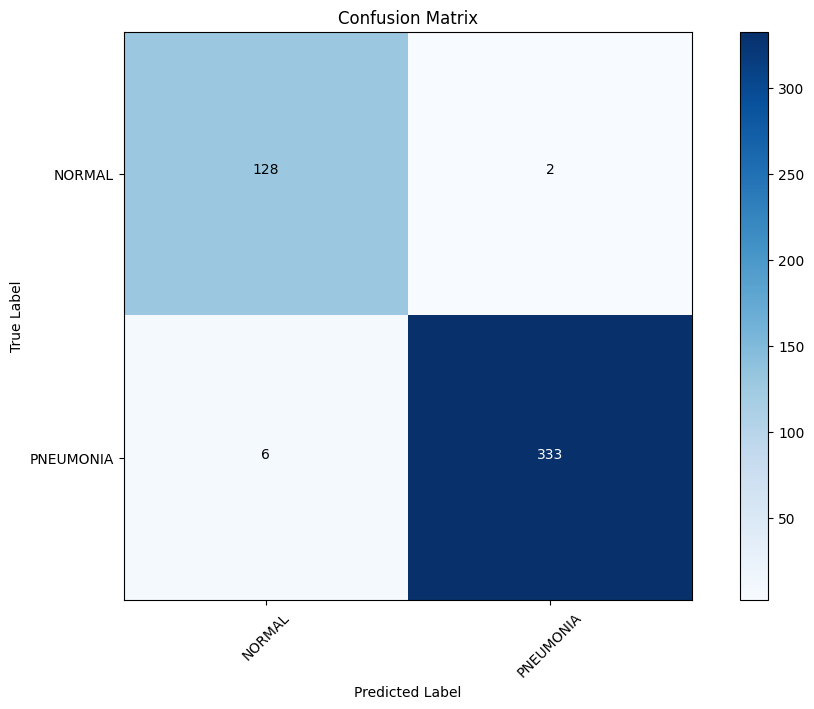

In [33]:
import itertools
from sklearn.metrics import confusion_matrix

# Extract class information from the generator
class_indices = test_gen.class_indices
classes = list(class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_gen.classes, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set ticks and labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Set threshold for text color
thresh = conf_matrix.max() / 2.

# Display the values in the matrix
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
             color='white' if conf_matrix[i, j] > thresh else 'black')

# Set layout and labels
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()


In [34]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(test_gen.classes, predicted_labels, target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.96      0.98      0.97       130
   PNEUMONIA       0.99      0.98      0.99       339

    accuracy                           0.98       469
   macro avg       0.97      0.98      0.98       469
weighted avg       0.98      0.98      0.98       469



1/1 [==============================] - 16s 16s/step
AUC on Test Set: 0.9929


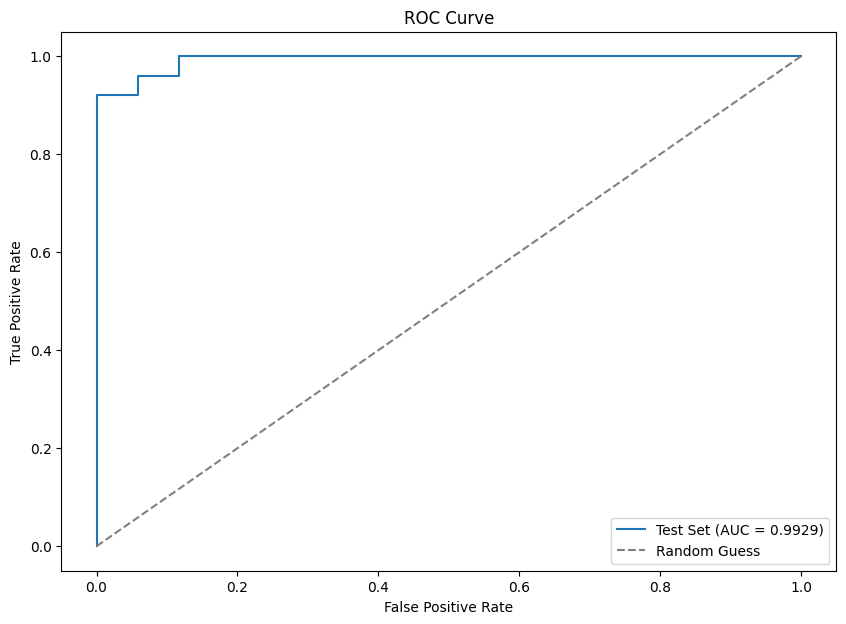

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Define the new batch size
new_batch_size = 16

# Calculate the new number of steps based on the new batch size
test_steps = len(test_gen) // new_batch_size + int(len(test_gen) % new_batch_size != 0)

# Predict probabilities for the test set with the new batch size
test_probabilities = chexnet_model.predict(test_gen, steps=test_steps)

test_predictions = test_probabilities[:, 1]

# Get true labels for test set
test_true_labels = test_gen.classes[:len(test_predictions)]

# Calculate AUC for test set
test_auc = roc_auc_score(test_true_labels, test_predictions)

print(f"AUC on Test Set: {test_auc:.4f}")

# Plot ROC curves for test set
fpr_test, tpr_test, _ = roc_curve(test_true_labels, test_predictions)

plt.figure(figsize=(10, 7))
plt.plot(fpr_test, tpr_test, label=f'Test Set (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [35]:
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import load_model


chexnet_model = load_model('/content/chexnet_model.h5')

image_path = '/content/Normal.jpeg'
image = Image.open(image_path)

# Convert grayscale to RGB
img_rgb = Image.new("RGB", image.size)
img_rgb.paste(image)

# Preprocess the image
img = img_rgb.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = chexnet_model.predict(img_array)
class_labels = ['Normal', 'Pneumonia']
score = tf.nn.softmax(predictions[0])
predicted_class = class_labels[tf.argmax(score)]
confidence = 100 * tf.reduce_max(score)

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

1/1 [==============================] - 6s 6s/step
Predicted class: Normal
Confidence: 73.09%


1/1 [==============================] - 4s 4s/step
Predicted class: Pneumonia
Confidence: 73.10%


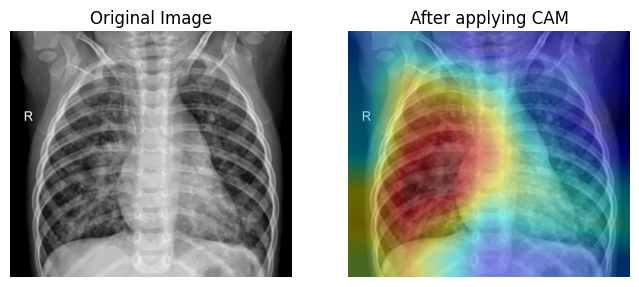

In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

# Load the model
model = load_model('/content/chexnet_model.h5')

# Load and preprocess the example image
image_path = '/content/Pneumonia.jpeg'
img = Image.open(image_path).convert("RGB")
img = img.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = model.predict(img_array)
class_labels = ['Normal', 'Pneumonia']
score = tf.nn.softmax(predictions[0])
predicted_class = class_labels[tf.argmax(score)]
confidence = 100 * tf.reduce_max(score)

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

# Get the last convolutional layer
last_conv_layer = model.get_layer('conv5_block16_concat')

# Create a model that outputs the last convolutional layer and the final model output
cam_model = tf.keras.Model(inputs=model.input, outputs=(last_conv_layer.output, model.output))

# Use GradientTape to compute gradients
x = img_array  # Use the preprocessed image as input
with tf.GradientTape() as tape:
    last_conv_output, preds = cam_model(x)
    class_output = preds[:, tf.argmax(score)]

# Compute gradients and pooled gradients
grads = tape.gradient(class_output, last_conv_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply the last convolutional layer's output with pooled gradients to get the heatmap
last_conv_output = last_conv_output[0]
heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)

# Read and resize the original image
original_img = cv2.imread(image_path)
height, width, _ = original_img.shape
heatmap = heatmap.numpy()
heatmap = cv2.resize(heatmap, (width, height))
heatmap = (heatmap * 255).astype(np.uint8)

# Apply the heatmap on the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

# Save the result to 'cam.jpg'
cv2.imwrite('cam.jpg', superimposed_img)

# Display the original image and the image with applied CAM side by side using Matplotlib
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('After applying CAM')
plt.axis('off')

plt.show()